# **Final simulation script**

## Pre-code

### Needs

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import random

cos = np.cos
sin = np.sin
pi = np.pi

g = 9.8    # NOTE: gravity defined as positive
inf = float('inf')

### Coin

In [2]:
r = 0.011   # Radius
h = 0.002   # Height
z_star = np.sqrt(r**2 + (h/2)**2)   # Z*
theta_c = np.arctan(h / (2 * r))  # Critical angle
m = 0.0075  # Mass of the coin
I_moment = (m / 4) * r**2 + (m / 12) * h**2   # Inertial moment
E_c = m * g * (z_star)  # Critical energy
gamma = 0.7   # Elasticity coefficient
corners = [(1, 1), (1, -1), (-1, 1), (-1, -1)]  # Corners

## Define **functions**

### KINEMATICS (Equations of Motion)

In [3]:
def z(t, z_0, v_0):
    """
    Calculates the vertical position of the Center of Mass (COM).
    Equation: z(t) = z0 + v0*t - 0.5*g*t^2
    """
    return z_0 + v_0*t - 0.5*g*t**2

def v(t, v_0):
    """
    Calculates the vertical velocity of the COM.
    Equation: v(t) = v0 - g*t
    """
    return v_0 - g*t

def theta(t, theta_0, w):
    """
    Calculates the angular orientation of the coin.
    Equation: theta(t) = theta0 + w*t
    """
    return theta_0 + w*t

### GEOMETRY (Corner Positions)

In [4]:
def alpha(t, j1, j2, theta_0, w):
    """
    Calculates the instantaneous phase angle for a specific corner.

    Parameters:
    -----------
    j1 : int (+1 or -1) -> Horizontal selector (Right/Left)
    j2 : int (+1 or -1) -> Vertical selector (Top/Bottom)

    Returns:
    --------
    float : The angle used inside the cosine/sine functions for position.
    """
    return theta_c + j1*j2*theta(t, theta_0, w)

def Z_j1j2(t, j1, j2, z_0, v_0, theta_0, w):
    """
    Calculates the exact vertical height (Z) of a specific corner.
    Logic: Height of COM + Vertical projection of the corner radius.
    """
    return z(t, z_0, v_0) + j2 * z_star * cos(alpha(t, j1, j2, theta_0, w))

### ENERGY (Total Energy of the coin)

In [5]:
def energy(z, v, w):
  """
  Calculates the total energy of the coin.
  Equation: E = mgz + 0.5mv^2 + 0.5Iw^2
  """
  return m*g*z + 0.5*m*v**2 + 0.5*I_moment*w**2

### NORM ANGLE [-pi, +pi)

In [6]:
def norm_angle(angle):
  """
  Normalizes an angle to the range [-pi, pi).
  """
  # 1. Angle to [0, 2pi)
  angle_norm = angle % (2 * pi)

  # 2. Angle to [-pi, pi)
  if angle_norm > pi:
    angle_norm -= 2 * pi

  return angle_norm

### UPDATE VARIABLES (No collision)

In [7]:
def update_state(z_curr, v_curr, theta_curr, w, dt):
    """
    Updates the state of the coin without a collision.
    Takes the current COM height, velocity, angle, and angular velocity (and time 0) as initials.
    Returns the new COM height, velocity, and angle after time 'dt'.
    """
    z_new = z(dt, z_curr, v_curr)
    v_new = v(dt, v_curr)
    theta_new = theta(dt, theta_curr, w)
    return z_new, v_new, theta_new

### REACHING Z*

In [8]:
def falling_impact_study_time(z_0, v_0, direction):
    """
    ANALYTICAL SOLVER for Center of Mass height.
    Finds the time 't' when the COM reaches the critical height 'z_star'.

    Objective:
    ----------
    To know when the coin reaches Z*, the state we want to study.

    Equation:
    ---------
    -0.5*g*t^2 + v_0*t + (z_0 - z_star) = 0

    Parameters:
    -----------
    direction : int
        1 -> Search for time when passing z_star while going UP (Escape).
        0 -> Search for time when passing z_star while going DOWN (Falling).

    Returns:
    --------
    float or None : The smallest positive time 't', or None if unreachable.
    """
    # Quadratic coefficients for the equation
    a = -0.5 * g
    b = v_0
    c = z_0 - z_star

    delta = b**2 - 4*a*c

    if delta < 0:
        return None # Coin apex is lower than z_star

    sqrt_delta = np.sqrt(delta)
    t1 = (-b - sqrt_delta) / (2*a)
    t2 = (-b + sqrt_delta) / (2*a)

    candidates = sorted([t1, t2])

    # Find the first valid time matching the direction criteria
    for t in candidates:
        if t >= 0: # Only future events
            current_vel = v(t, v_0)
            if direction == 1 and current_vel >= 0:  # If is going up and you want it
                return t
            elif direction == 0 and current_vel <= 0:  # If is going down and you want it
                return t

    return None

### WHICH CORNER COLLIDES

In [9]:
def solve_collision_time(j1, j2, z_0, v_0, theta_0, w, min_t=-1e-9):
    """
    NUMERICAL SOLVER (Taylor Expansion) for Corner Impact.
    Approximates the time 'dt' until a specific corner hits Z=0.

    Objective:
    ----------
    Because Z_j1j2(t) involves cos(t) and t^2, it cannot be solved analytically.
    We use a 2nd-order Taylor expansion around t=0 (current state) to approximate
    the trajectory as a parabola locally and find the root.

    Taylor Expansion:
    -----------------

    Parameters:
    -----------
    min_t (float) : Minimum time to consider (to avoid errors).

    Returns:
    --------
    float or None : The time 'dt' that approximates when the coin collides or None.
    """
    # 1. Evaluate state at t_study
    z_com = z_0  # Current COM height
    v_com = v_0  # Current COM velocity
    alpha_val = alpha(0, j1, j2, theta_0, w)

    cos_a = cos(alpha_val)
    sin_a = sin(alpha_val)

    # 2. Taylor Coefficients ( Z_j1j2(t) ≈ A*t^2 + B*t + C )

    # C = Current Position
    C_coeff = z_com + j2 * z_star * cos_a

    # B = Current Velocity (Linear + Rotational contribution)
    B_coeff = v_com - (j1 * z_star * w * sin_a)

    # A = Current Acceleration (Gravity + Centripetal) / 2
    accel_total = -g - (j2 * z_star * (w**2) * cos_a)
    A_coeff = 0.5 * accel_total

    # 3. Solve Quadratic
    delta = B_coeff**2 - 4*A_coeff*C_coeff
    if delta < 0: return None

    sqrt_delta = np.sqrt(delta)
    t1 = (-B_coeff - sqrt_delta) / (2*A_coeff)
    t2 = (-B_coeff + sqrt_delta) / (2*A_coeff)

    # 4. Filter Results (absolute time must be > 0)
    candidates = []
    for t in [t1, t2]:
        if t > min_t:
          if t < 0: t=0   # if we find that the coin collides at t=-1e-10 we will say that collides at t=0
          candidates.append(t)

    if not candidates: return None
    return min(candidates)


def find_next_impact(z_0, v_0, theta_0, w, min_t=-1e-9):
    """
    MANAGER for Impact Detection.
    Checks all 4 corners to see which one hits the floor first.

    Returns:
    --------
    np.array : [j1, j2, absolute_time] with the corner that hits first and the approximated time.
    """
    check_order = list(corners) # Copia la llista
    random.shuffle(check_order) # Barreja l'ordre aleatòriament

    valid_impacts = []

    for (j1, j2) in check_order:
        dt = solve_collision_time(j1, j2, z_0, v_0, theta_0, w, min_t)
        if dt is not None:
            valid_impacts.append([j1, j2, dt])

    if not valid_impacts: return None

    # Sort by time (smallest time is the first impact)
    valid_impacts.sort(key=lambda x: x[2])
    return np.array(valid_impacts[0])

### FIND COLLISION

In [10]:
def simulate_until_impact(z_ini, v_ini, theta_ini, w_ini, min_t=-1e-5, t_max=inf):
    """
    ITERATIVE LOOP to find exact impact time.

    Objective:
    ----------
    Taylor expansion is only accurate locally. This function advances the simulation
    step-by-step, recalculating the Taylor approximation as it gets closer to the floor,
    until the error is negligible (< 0.1 microseconds).
    """
    curr_z = z_ini
    curr_v = v_ini
    curr_theta = theta_ini
    total_time = 0.0

    precision_limit = 1e-8
    max_steps = 10000
    first = True

    for i in range(max_steps):
        # Search from t=0 (current state)
        if first:
            t_min = min_t
            first = False
        else:
            t_min = -1e-9

        impact = find_next_impact(curr_z, curr_v, curr_theta, w_ini, t_min)

        if impact is None: return None # No impact found

        j1, j2, dt = impact

        curr_z, curr_v, curr_theta = update_state(curr_z, curr_v, curr_theta, w_ini, dt)
        total_time += dt

        if total_time > t_max: return None # Time limit exceeded

        # Check convergence
        if dt < precision_limit:
            return [int(j1), int(j2), total_time, curr_z, curr_v, curr_theta]

    return None

### UPDATE VARIABLES (Post collision)

In [11]:
def resolve_bounce(v_old, w_old, theta_impact, j1, j2):
    """
    Calculates the new velocities after the collision.
    ADAPTATION: Uses the logic and formulas derived in class.
    """

    # 1. Local Variables
    v = v_old
    w = w_old

    # IMPORTANT: Normalize theta to range [-PI, PI]
    # We use the existing helper function for consistency
    theta = norm_angle(theta_impact)

    # 2. CALCULATION OF 'y' (Lever Arm)
    # Determines the horizontal distance to contact point based on angle quadrants
    if (theta >= 0 and theta < pi/2) or (theta > -pi and theta < -pi/2):
        y = z_star * np.sin(abs(theta) - theta_c)
    else:
        y = -z_star * np.sin(abs(theta) - theta_c)

    # 3. MOMENT OF INERTIA (Class Formula)
    # Formula for a solid cylinder rotating around central diameter
    I = I_moment

    # 4. CALCULATION OF VELOCITY CHANGES (Class Formulas)
    # Calculating the impulse effects on linear (v) and angular (w) velocity
    v_change = -(1 + gamma) * (I / (I + m*y**2)) * (v + y*w)
    w_change = -(1 + gamma) * (m*y / (I + m*y**2)) * (v + y*w)

    # 5. UPDATE AND RETURN
    v += v_change
    w += w_change

    return v, w

### NEXT EVENT

In [12]:
def check_next_event(z_curr, v_curr, theta_curr, w_curr):
    """
    DECISION MAKER: What happens next?

    Objective:
    ----------
    After a bounce, the coin is moving up. We need to know if:
    A) It hits the floor again immediately (Chattering/Trapped).
    B) It has enough energy to rise above z_star (Escape/Free Flight).

    Returns:
    --------
    dict : Event type ("IMPACT" or "ESCAPE") and time to event.
    """

    # A. Check time to Escape (reach z_star)
    if z_curr > z_star:
        dt_escape = 0.0 # Already escaped
    else:
        dt_escape = falling_impact_study_time(z_curr, v_curr, direction=1)
        if dt_escape is None: dt_escape = inf

    # B. Check time to next Impact before escape (min_t > 0 because we want a future collision)
    impact_data = simulate_until_impact(z_curr, v_curr, theta_curr, w_curr, min_t=1e-5, t_max=dt_escape)

    if impact_data is not None:
        dt_impact = impact_data[2]
        j1 = impact_data[0]
        j2 = impact_data[1]
        curr_z = impact_data[3]
        curr_v = impact_data[4]
        curr_theta = impact_data[5]
        impact_details = (j1, j2, curr_z, curr_v, curr_theta)

    else:
        dt_impact = inf
        impact_details = None


    # C. Compare
    if dt_impact == inf and dt_escape == inf:
        z_sim, v_sim, th_sim = z_curr, v_curr, theta_curr
        t_accum = 0.0
        step = 0.05
        for _ in range(100):
          z_next, v_next, th_next = update_state(z_sim, v_sim, th_sim, w_curr, step)
          if safe_pos(z_next, v_next, th_next, w_curr):
              z_sim, v_sim, th_sim = z_next, v_next, th_next
              t_accum += step
              local_impact = simulate_until_impact(z_sim, v_sim, th_sim, w_curr, min_t=1e-6, t_max=step*2)
              if local_impact is not None:
                  total_dt = t_accum + local_impact[2]
                  j1 = local_impact[0]
                  j2 = local_impact[1]
                  curr_z = local_impact[3]
                  curr_v = local_impact[4]
                  curr_theta = local_impact[5]
                  impact_details = (j1, j2, curr_z, curr_v, curr_theta)
                  return {"type": "IMPACT", "dt": total_dt, "details": impact_details}
              else: continue
          else:
              step = step / 10.0

        return {"type": "ERROR", "dt": None, "details": None}

    elif dt_impact < dt_escape:
        return {"type": "IMPACT", "dt": dt_impact, "details": impact_details}
    else:
        return {"type": "ESCAPE", "dt": dt_escape, "details": None}

### DETERMINE OUTCOME

In [13]:
import numpy as np

def determine_outcome_by_angle(theta_final, theta_c):
    """
    Determines the outcome by normalizing the angle to [-pi, pi].

    MODEL GEOMETRY (based on your cosine height function):
    - 0 rad and +/-PI rad  -> Maximum Cosine -> STANDING (Edge)
    - +/- PI/2 rad         -> Minimum Cosine -> FLAT (Heads/Tails)
    """

    # 1. Normalize angle to [-pi, pi]
    # We use the helper function defined previously
    angle = norm_angle(theta_final)

    # Now 'angle' is always between -3.14 and 3.14

    # 2. REGION DEFINITION

    # --- EDGE ZONES (Verticals) ---
    # The coin is on its edge when vertical (angle 0 or angle pi/-pi)

    # Case 1: Around 0 radians
    if -theta_c <= angle <= theta_c:
        return "CANTÓ (Edge)"

    # Case 2: Around +/- pi radians (the ends of the interval)
    # Checks if we are close to pi or close to -pi
    elif (angle >= np.pi - theta_c) or (angle <= -np.pi + theta_c):
        return "CANTÓ (Edge)"

    # --- FACE ZONES (Flats) ---
    # If it is not Edge, it must be Heads or Tails.
    # These correspond to the horizontal positions around +/- pi/2.

    # Case Heads/Tails 1 (Positive half, around pi/2)
    elif 0 < angle <= np.pi:
        return "CARA (Heads)"

    elif -np.pi <= angle < 0:
        return "CREU (Tails)"

    else:
        return f"ERROR (Angle: {angle})"

# Wrapper for compatibility with the main simulation loop
def determine_final_outcome(theta_f):
    return determine_outcome_by_angle(theta_f, theta_c)

### SAFE POS

In [14]:
def safe_pos(z_0, v_0, theta_0, w):
  """
  To see if the coin is under the floor
  """
  corners = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
  for j1, j2 in corners:
    h = Z_j1j2(0, j1, j2, z_0, v_0, theta_0, w)
    if h<0: return False
  return True

### SOLVE SLIDING

In [15]:
def slide_until_cusp(z_curr, v_curr, theta_curr, w_curr, j1, j2):
    """
    Simula el lliscament fins a la propera singularitat geomètrica (Cusp).
    Basat en Murray & Teare (1993), Eq. 10-13 i Discussió p. 2550.
    """

    # --- 1. IDENTIFICAR L'OBJECTIU (CUSP) ---
    # "When the coin reaches a cusp... which can occur at theta = n(pi/2)"
    pi_2 = np.pi / 2

    # Determinem la direcció i el següent múltiple de 90 graus
    if w_curr > 0:
        target_k = np.floor(theta_curr / pi_2) + 1
    else:
        target_k = np.ceil(theta_curr / pi_2) - 1

    theta_new = target_k * pi_2

    # Correcció: Si ja som a la cúspide (per error numèric), forcem avançar a la següent
    if abs(theta_new - theta_curr) < 1e-5:
        theta_new += (pi_2 if w_curr > 0 else -pi_2)

    # --- 2. NOVA POSICIÓ (GEOMETRIA) ---
    # "The coin can move continuously along this curve"
    # Imosem la restricció Z_corner = 0
    alpha_new = alpha(0, j1, j2, theta_new, 0)
    z_new = -1 * j2 * z_star * np.cos(alpha_new)

    if z_new < 0: z_new = 0.0 # Clamp de seguretat

    # --- 3. CONSERVACIÓ D'ENERGIA ---
    # "No loss of energy... depends on kinetic energy available"

    # Energia Total Inicial (Conservada)
    E_total = m * g * z_curr + 0.5 * m * v_curr**2 + 0.5 * I_moment * w_curr**2

    # Factor geomètric derivat de la restricció v = f(w)
    # v = dz/dt = d/dt (-j2*z*cos(alpha)) = j2*z*sin(alpha) * (j1*j2*w) = j1*z*sin(alpha)*w
    geo_factor = j1 * z_star * np.sin(alpha_new)

    # Nova Energia Potencial
    U_new = m * g * z_new

    # Energia Cinètica disponible
    K_available = E_total - U_new

    if K_available < 0:
        # "The coin cannot reverse direction... along the collision line"
        # Si no té energia per arribar-hi, es queda on és (o cau enrere, però aquí parem).
        return z_curr, 0.0, theta_curr, 0.0

    # Resoldre w_new
    # K = 0.5 * m * v^2 + 0.5 * I * w^2
    # K = 0.5 * w^2 * (m * geo_factor^2 + I)
    inertia_effective = (m * (geo_factor**2) + I_moment)
    w_magnitude = np.sqrt(2 * K_available / inertia_effective)

    w_new = w_magnitude if w_curr > 0 else -w_magnitude
    v_new = geo_factor * w_new

    # --- 4. TRANSICIÓ (IMPULS) ---
    # "Continue the motion as if the coin is colliding with the floor with contact
    # only at the corner that is coming into new contact".

    # IMPORTANT: A la cúspide (pi/2), la moneda està PLANA.
    # Tècnicament, entra en contacte la 'nova' cantonada.
    # Però com que Z=0 per a totes dues, podem usar la funció de xoc estàndard
    # sobre l'estat actual i la física resoldrà la discontinuïtat de velocitat.

    v_final, w_final = resolve_bounce(v_new, w_new, theta_new, j1, j2)

    return z_new, v_final, theta_new, w_final

## SIMULATE 1 TOSS

In [28]:
# ==========================================
# 1. INITIAL VARIABLES
# ==========================================
z_0 = 1
v_0 = 23
theta_0 = 0
w = 30

# ==========================================
# 2. SIMULATION
# ==========================================

#----------------------------------------------------------------------------------------
# Starting variables
z_curr, v_curr, theta_curr, w_curr = z_0, v_0, theta_0, w
t_total = 0.0   # Time between the toss starts and the outcome is determined
bounce_count = 0    # How many bounces the coin does
max_bounces = 100   # To stop simulation -> if the coin bounces 100 times it's an ERROR
outcome = None    # To know if the code has some error
#------------------------------------------------------------------------------------------

#-----------------------------------------------------
# The toss is legal?
simulating = safe_pos(z_0, v_0, theta_0, w)

if simulating:
  print(f"--- INICI LLANÇAMENT (z0={z_0:.2f}m, v0={v_0:.2f}m/s, theta0={theta_0:.2f}rad, w0={w:.2f}rad/s) ---")
else:
  print(f"ERROR: Z0 massa baix.")
#-----------------------------------------------------

while simulating and bounce_count < max_bounces:
    # Is it the outcome determined?
    E_total = energy(z_curr, v_curr, w_curr)
    if E_total < E_c:
        print(f"--> Now, at t_final={t_total}s we have E={E_total:.5f} < E_c={E_c:.5f} => Simulation finished")
        simulating = False
        break
    # ------------------------------------------------------------------------
    # A) WE WANT TO ARRIVE TO THE MOMENT THAT Z<=Z* AND NEXT EVENT IS BOUNCING
    # ------------------------------------------------------------------------
    print("\n" + "-"*20)
    # If we are  >Z*, we go to the moment that the coin reaches Z* going down (v<0)
    if z_curr > z_star:
        print(f"Now, at time {t_total:.4f}s, the coin is at a height z={z_curr:.4f} > Z*={z_star:.4f}")
        # Calculate the time to reach Z*
        t_fall = falling_impact_study_time(z_curr, v_curr, direction=0)
        if t_fall:
            z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, t_fall)
            t_total += t_fall
            print(f"The coin will reach z = Z* going down in {t_fall:.4}s, at time {t_total:.4f}s")
        else:
            print("Error, the coin doesn't reach Z* never (ERROR)")
            outcome = "ERROR"
            break

    if z_curr <= z_star:
        print(f"Now, at time {t_total:.4f}s, the coin is at a height z={z_curr:.4f} <= Z*={z_star:.4f}")
        # If we are <=Z*, then we have two opcions:
        #   1. coin is going down (v<0) so it's clear the next event is going to be a collision
        #   2. coin is going up (v>0) so we need to solve the case that escapes
        if v_curr <=0:
            print(f"The coin is going down (v={v_curr:.4f}<=0), so is going to collide")

        if v_curr > 0:
            print(f"The coin is going up (v={v_curr:.4f}>0), so it can collide or escape")
            next_ev = check_next_event(z_curr, v_curr, theta_curr, w_curr)

            #  If it escapes, we move to the moment when the coin arrives to Z* going down
            if next_ev['type'] == 'ESCAPE':
                dt = next_ev['dt']
                print(f"The coin escaped to a height > Z* in {dt:.4f}s")

                # Calculate the time to reach Z* going down
                t_fall = falling_impact_study_time(z_curr, v_curr, direction=0)
                if t_fall:
                    # We move to the moment when the coin arrives to Z* going down
                    z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, t_fall)
                    t_total += t_fall
                    print(f"The coin will reach z = Z* going down at time {t_total:.4f}s")
                else:
                    print("Error, the coin doesn't reach Z* never (ERROR)")
                    outcome = "ERROR"
                    break

            else:
                print("Even though the coin is going up, is going to collide before escape")

    # At this point the next thing is going to be a collision

    # ---------------------------------------------------
    # B) SOLVE THE EXACT IMPACT
    # ---------------------------------------------------

    # Simulate the impact
    impacte = simulate_until_impact(z_curr, v_curr, theta_curr, w_curr)

    # If we don't find an impact (error) -> Taylor is not good for big times, so we move 0.01s
    if impacte is None:
        print("Error, the coin didn't impact")
        z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, 0.01)
        continue

    # If we found an impact, we move to the exact collision
    j1, j2 = impacte[0], impacte[1]
    t_recorregut = impacte[2]
    z_curr = impacte[3]
    v_curr = impacte[4]
    theta_curr = impacte[5]

    t_total += t_recorregut
    bounce_count += 1
    print(f"Now, at time {t_total:.4f}s the coin has collideded")
    print(f"The time between we started studying the collision and it happened was {t_recorregut:.4f}")
    print(f"BOUNCE {bounce_count}: v_impact={v_curr:.6f} | w_impact={w_curr:.6f}")

    # At this point the coin has collided

    # ---------------------------------------------------
    # C) UPDATE VALUES PRE/POST COLLISION
    # ---------------------------------------------------

    # We update v and w because of the impact
    v_curr, w_curr = resolve_bounce(v_curr, w_curr, theta_curr, j1, j2)
    print(f"After the collision, the new velocity is v={v_curr:.4f} and the angular velocity is w={w_curr:.4f}")

    # Is it the outcome determined?
    E_total = energy(z_curr, v_curr, w_curr)
    if E_total < E_c:
        print(f"--> Now, after collision, at t_final={t_total}s we have E={E_total:.5f} < E_c={E_c:.5f} => Simulation finished")
        simulating = False
        break

    # At this point the coin has to bounce but we have so many opcions:
    #   A. The coin reaches Z* going up before any corner collides ->
    #      -> we move to the moment that reaches z* but going down
    #   B. A diferent corner collides before the coin reaches Z*
    #   C. The same corner collides (because it's slideing)

    # A and B are solved if we continue the while, so we just have to solve the C

    # ---------------------------------------------------
    # D) WHAT HAPPENS NEXT?
    # ---------------------------------------------------

    # If the coin still going down, the coin is slideing
    if v_curr <= 0:
      print("After collision the velocity is negative, so the coin slides")
      sliding = True

    # If the coin is going up we need to see if the next event is anothe collision with the same corner, fast and weak
    else:
        print("After collision the velocity is positive")
        next_ev = check_next_event(z_curr, v_curr, theta_curr, w_curr)

        sliding = False

        if next_ev['type'] == 'ERROR':
            print("It happened something bad")
            outcome = "ERROR"
            break

        if next_ev['type'] == 'IMPACT':
            # The coin is going to collide before escape
            print("The coin will collide before escape")
            dt = next_ev['dt']
            j1_next, j2_next = next_ev['details'][0], next_ev['details'][1]

            # SLIDING CONDITIONS
            pivoting = (j1_next == j1 and j2_next == j2)
            fast = (dt < 1e-8)
            weak = (abs(v_curr) < 0.5)

            if pivoting and fast and weak:
              # If this happens the coin will slide
              print("The coin is sliding")
              sliding = True

            else:
              # The coin won't slide, but we now that is going to collide before escape
              print("The coin is not sliding")
              # We move a little bit to the next collision (with this we ensure the coin is not touching the floor)
              z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, dt/2)
              continue

        elif next_ev['type'] == 'ESCAPE':
            # The coin is going to escape before colliding
            print("The coin will escape to a height > Z*")
            dt = next_ev['dt']
            z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, dt+1e-5)
            continue

    if sliding:
        print(f"   [SLIDING START] Theta: {theta_curr:.2f}")

        # 1. CAPTURAR EL RESULTAT (Correcte: Ara recollim els 4 valors que retorna)
        # Nota: v_new i w_new ja inclouen el 'kick' de resolve_bounce del final de la funció.
        z_new, v_new, theta_new, w_new = slide_until_cusp(z_curr, v_curr, theta_curr, w_curr, j1, j2)

        # 2. CALCULAR EL TEMPS DE LLISCAMENT (Física: t = distància / velocitat)
        # La funció slide mou la moneda, però no ens diu quant triga. Ho estimem:
        # Usem la velocitat angular mitjana entre l'inici i el final del lliscament.
        # (Nota: w_curr és l'inicial, w_new és la final post-xoc.
        #  Per ser més precisos amb el temps de lliscament, idealment voldríem la w just abans del xoc,
        #  però la mitjana és una aproximació suficientment bona per a simulació estocàstica).

        w_avg = (w_curr + w_new) / 2.0

        # Evitem dividir per zero
        if abs(w_avg) > 1e-9:
             dt_slide = abs(theta_new - theta_curr) / abs(w_avg)
        else:
             dt_slide = 0.0

        # 3. ACTUALITZAR L'ESTAT PRINCIPAL
        # Això és el que faltava: traspassar els valors nous a les variables del bucle
        z_curr = z_new
        v_curr = v_new
        theta_curr = theta_new
        w_curr = w_new

        # 4. ACTUALITZAR COMPTADORS
        t_total += dt_slide
        bounce_count += 1 # El 'kick' final compta com un rebot tècnic
        print(f"Now, at time {t_total:.4f}s the coin has finished slideing")
        print(f"The time between we started studying the collision and it happened was {dt_slide:.4f}")
        print(f"BOUNCE {bounce_count}: v_impact={v_curr:.6f} | w_impact={w_curr:.6f}")
        print(f"   [SLIDING END] Theta: {theta_curr:.2f}")

        # 5. REINICIAR EL BUCLE (Important!)
        # Ara tenim una nova velocitat (v_curr > 0 gràcies al kick) i nova posició.
        # Tornem a dalt de tot (Fase A) perquè el 'Decision Maker' decideixi
        # si la moneda s'escapa o torna a caure.
        #print("Now, the impact will be at dt=0")
        continue

if outcome is None:
    outcome = determine_final_outcome(theta_curr)

# ==========================================
# RESULTATS
# ==========================================
print("\n" + "="*30)
print(f"TEMPS TOTAL:    {t_total:.6f} s")
print(f"Rebots totals:  {bounce_count}")
print(f"Angle Final:    {norm_angle(theta_curr):.4f} rad")
print(f"RESULTAT:       {outcome}")
print("="*30)

--- INICI LLANÇAMENT (z0=1.00m, v0=23.00m/s, theta0=0.00rad, w0=30.00rad/s) ---

--------------------
Now, at time 0.0000s, the coin is at a height z=1.0000 > Z*=0.0110
The coin will reach z = Z* going down in 4.736s, at time 4.7365s
Now, at time 4.7366s the coin has collideded
The time between we started studying the collision and it happened was 0.0001
BOUNCE 1: v_impact=-23.418491 | w_impact=30.000000
After the collision, the new velocity is v=-10.7826 and the angular velocity is w=3355.4027
After collision the velocity is negative, so the coin slides
   [SLIDING START] Theta: 142.10
Now, at time 4.7369s the coin has finished slideing
The time between we started studying the collision and it happened was 0.0003
BOUNCE 2: v_impact=-19.177827 | w_impact=1743.438818
   [SLIDING END] Theta: 142.94

--------------------
Now, at time 4.7369s, the coin is at a height z=0.0010 <= Z*=0.0110
The coin is going down (v=-19.1778<=0), so is going to collide
Now, at time 4.7369s the coin has colli

## SIMULATE N TOSSES

In [17]:
def simulate_single_toss(z_ini, v_ini, theta_ini, w_ini):
    z_curr, v_curr, theta_curr, w_curr = z_ini, v_ini, theta_ini, w_ini
    t_total = 0.0
    bounce_count = 0
    max_bounces = 300
    dt_slide_limit = 1e-7

    simulating = safe_pos(z_curr, v_curr, theta_curr, w_curr)

    """
    if simulating:
      print(f"--- INICI LLANÇAMENT (z0={z_ini:.2f}m, v0={v_ini:.2f}m/s, theta0={theta_ini:.2f}rad, w0={w_ini:.2f}rad/s) ---")
    else:
      print(f"ERROR: Z0 massa baix.")

    """
    while simulating and bounce_count < max_bounces:


        # -------------------------------------------------------------------------
        # A) WE WANT TO ARRIVE TO THE MOMENT THAT Z<=Z* AND NEXT EVENT IS BOUNCING
        # ------------------------------------------------------------------------

        # If we are upper than Z*, we go to the moment that the coin reaches Z* going down
        if z_curr > z_star:
            t_fall = falling_impact_study_time(z_curr, v_curr, direction=0)

            if t_fall:
                z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, t_fall)
                t_total += t_fall
            else:
                print("Error")
                break

        # If we are <=Z*, then we have two opcions:
        #   1. coin is going down (v<0) so it's clear the next event is going to be a collision
        #   2. coin is going up (v>0) so we need to solve the case that escapes
        elif v_curr > 0:

            next_ev = check_next_event(z_curr, v_curr, theta_curr, w_curr)

            #  If escapes, we move to the moment when the coin arrives to Z* going down
            if next_ev['type'] == 'ESCAPE':
                t_fall = falling_impact_study_time(z_curr, v_curr, direction=0)
                if t_fall:
                    z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, t_fall)
                    t_total += t_fall
                else:
                    break # Error físic

        # At this point the next thing is going to be a collision

        # ---------------------------------------------------
        # B) SOLVE THE EXACT IMPACT
        # ---------------------------------------------------

        # Simulate the impact
        impacte = simulate_until_impact(z_curr, v_curr, theta_curr, w_curr)

        # If we don't find an impact (error)
        if impacte is None:
            print("Error, no impact")
            z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, 0.001)
            continue

        # We move to the exact collision
        j1, j2 = impacte[0], impacte[1]
        t_recorregut = impacte[2]
        z_curr = impacte[3]
        v_curr = impacte[4]
        theta_curr = impacte[5]

        t_total += t_recorregut
        bounce_count += 1

        #print(f"BOUNCE {bounce_count}: t_acumulat={t_total:.6f}s | v_impact={v_curr:.6f} | w_impact={w_curr:.6f}")

        # At this point the coin has collided

        # ---------------------------------------------------
        # C) UPDATE VALUES PRE/POST COLLISION
        # ---------------------------------------------------

        v_curr, w_curr = resolve_bounce(v_curr, w_curr, theta_curr, j1, j2)
        #print(f"v_new={v_curr:.3f}")

        # Is it the outcome determined?
        E_total = energy(z_curr, v_curr, w_curr)
        if E_total < E_c:
            #print(f"--> Aterratge per falta d'energia (E={E_total:.5f}).")
            simulating = False
            break

        # At this point the coin has to bounce but we have so many opcions:
        #   A. The coin reaches Z* going up before any corner collides ->
        #      -> we move to the moment that reaches z* but going down
        #   B. A diferent corner collides before the coin reaches Z*
        #   C. The same corner collides (because it's slideing)

        # ---------------------------------------------------
        # D) WHAT HAPPENS NEXT?
        # ---------------------------------------------------

        if v_curr <= 0:
          sliding = True

        else:
            next_ev = check_next_event(z_curr, v_curr, theta_curr, w_curr)

            sliding = False

            if next_ev['type'] == 'ERROR':
                print("ERROR10")
                break

            if next_ev['type'] == 'IMPACT':
                dt = next_ev['dt']
                j1_next, j2_next = next_ev['details'][0], next_ev['details'][1]

                # SLIDING CONDITIONS
                pivoting = (j1_next == j1 and j2_next == j2)
                fast = (dt < 1e-4)
                weak = (abs(v_curr) < 0.5)

                if pivoting and fast and weak:
                  sliding = True

                else:
                  z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, dt/2)
                  continue

            elif next_ev['type'] == 'ESCAPE':
                dt = next_ev['dt']
                z_curr, v_curr, theta_curr = update_state(z_curr, v_curr, theta_curr, w_curr, dt)
                continue

        if sliding:
            #print(f"   [SLIDING START] Theta: {theta_curr:.2f} -> Buscant Cusp...")

            # 1. CAPTURAR EL RESULTAT (Correcte: Ara recollim els 4 valors que retorna)
            # Nota: v_new i w_new ja inclouen el 'kick' de resolve_bounce del final de la funció.
            z_new, v_new, theta_new, w_new = slide_until_cusp(z_curr, v_curr, theta_curr, w_curr, j1, j2)

            # 2. CALCULAR EL TEMPS DE LLISCAMENT (Física: t = distància / velocitat)
            # La funció slide mou la moneda, però no ens diu quant triga. Ho estimem:
            # Usem la velocitat angular mitjana entre l'inici i el final del lliscament.
            # (Nota: w_curr és l'inicial, w_new és la final post-xoc.
            #  Per ser més precisos amb el temps de lliscament, idealment voldríem la w just abans del xoc,
            #  però la mitjana és una aproximació suficientment bona per a simulació estocàstica).

            w_avg = (w_curr + w_new) / 2.0

            # Evitem dividir per zero
            if abs(w_avg) > 1e-9:
                dt_slide = abs(theta_new - theta_curr) / abs(w_avg)
            else:
                dt_slide = 0.0

            # 3. ACTUALITZAR L'ESTAT PRINCIPAL
            # Això és el que faltava: traspassar els valors nous a les variables del bucle
            z_curr = z_new
            v_curr = v_new
            theta_curr = theta_new
            w_curr = w_new

            # 4. ACTUALITZAR COMPTADORS
            t_total += dt_slide
            bounce_count += 1 # El 'kick' final compta com un rebot tècnic

            #print(f"   [SLIDING END] Theta: {theta_new:.2f} (durada: {dt_slide:.4f}s)")

            # 5. REINICIAR EL BUCLE (Important!)
            # Ara tenim una nova velocitat (v_curr > 0 gràcies al kick) i nova posició.
            # Tornem a dalt de tot (Fase A) perquè el 'Decision Maker' decideixi
            # si la moneda s'escapa o torna a caure.
            continue

    if bounce_count == max_bounces:
        outcome = "ERROR"
    else:
        outcome = determine_final_outcome(theta_curr)

    print(outcome)
    return outcome, t_total, bounce_count


In [18]:
z_0 = 13.263533729033519
v_0 = 2.403009737300052
theta_0 = 0.7994240370855489
w = 39.0949994438927

print("--- SIMULACIÓ CAS 24 ---")
outcome, temps, bounces= simulate_single_toss(z_0, v_0, theta_0, w)
print(f"Resultat: {outcome} | Temps: {temps:.4f}s | Bots: {bounces}")

--- SIMULACIÓ CAS 24 ---
CARA (Heads)
Resultat: CARA (Heads) | Temps: 8.1970s | Bots: 23


In [19]:
def get_random_toss_params():
    """ Genera condicions inicials aleatòries però realistes """
    z_val = np.random.uniform(1.0, 20.0)      # Altura mà (1m - 1.5m)
    v_val = np.random.uniform(-5.0, 10.0)      # Llançament cap amunt (2-5 m/s)
    # NOTA: v positiva vol dir cap amunt. La nostra funció 'v' ja resta g*t.

    th_val = np.random.uniform(0, 2*np.pi)   # Angle qualsevol
    w_val = np.random.uniform(5.0, 60.0)    # Rotació (10-40 rad/s)

    # Randomitzar sentit de gir
    if np.random.rand() > 0.5: w_val *= -1

    return z_val, v_val, th_val, w_val

Iniciant 500 simulacions Monte Carlo...
CARA (Heads)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CARA (Heads)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CREU (Tails)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CARA (Heads)
CREU (Tails)
CARA (Heads)
CREU (Tails)
CREU (Tails)
CARA (Heads)
CREU (Tails)
CARA (Heads

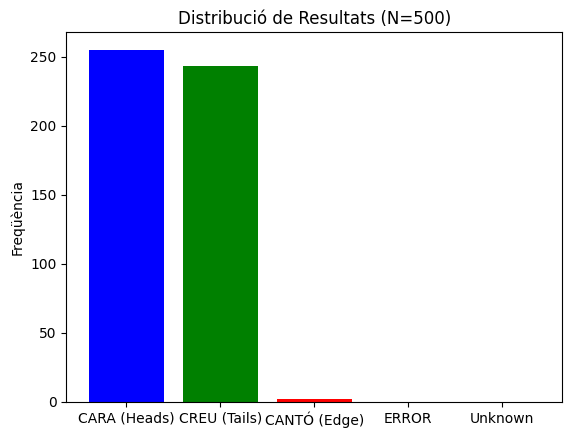

Probabilitat Teòrica (%):     0.0256%
Probabilitat Simulada:  0.4000%


In [20]:
# ==========================================
# 3. BUCLE MONTE CARLO
# ==========================================

def get_random_toss_params():
    """ Genera condicions inicials aleatòries però realistes """
    z_val = np.random.uniform(1.0, 20.0)      # Altura mà (1m - 1.5m)
    v_val = np.random.uniform(-5.0, 10.0)      # Llançament cap amunt (2-5 m/s)
    # NOTA: v positiva vol dir cap amunt. La nostra funció 'v' ja resta g*t.

    th_val = np.random.uniform(0, 2*np.pi)   # Angle qualsevol
    w_val = np.random.uniform(5.0, 60.0)    # Rotació (10-40 rad/s)

    # Randomitzar sentit de gir
    if np.random.rand() > 0.5: w_val *= -1

    return z_val, v_val, th_val, w_val

N_SIMS = 500 # Nombre de llançaments
results = {"CARA (Heads)": 0, "CREU (Tails)": 0, "CANTÓ (Edge)": 0, "ERROR": 0, "Unknown": 0}
times = []

print(f"Iniciant {N_SIMS} simulacions Monte Carlo...")

for i in range(N_SIMS):
    # 1. Generar condicions (Noms diferents per no matxucar funcions)
    z_sim, v_sim, th_sim, w_sim = get_random_toss_params()

    # 2. Simular
    res_str, t_dur, b = simulate_single_toss(z_sim, v_sim, th_sim, w_sim)

    # 3. Guardar dades
    if "CARA" in res_str:
      key = "CARA (Heads)"
      #print("cara")
    elif "CREU" in res_str:
      key = "CREU (Tails)"
      #print("creu")
    elif "CANTÓ" in res_str:
      key = "CANTÓ (Edge)"
      print(f"--- (z0={z_sim}, w0={w_sim}, v0={v_sim}, th0={th_sim} ) ---")
    else: key = "Unknown"

    results[key] += 1
    times.append(t_dur)

    if (i+1) % 10 == 0:
        #print(f"  Simulació {i+1}/{N_SIMS} completada...")
        pass
# ==========================================
# 4. RESULTATS ESTADÍSTICS
# ==========================================

print("\n" + "="*40)
print(f"RESULTATS FINALS ({N_SIMS} Llançaments)")
print("="*40)
print(f"CARA:   {results['CARA (Heads)']} ({results['CARA (Heads)']/N_SIMS*100:.4f}%)")
print(f"CREU:   {results['CREU (Tails)']} ({results['CREU (Tails)']/N_SIMS*100:.4f}%)")
print(f"CANTÓ:  {results['CANTÓ (Edge)']} ({results['CANTÓ (Edge)']/N_SIMS*100:.4f}%)")
print(f"Errors: {results['ERROR'] + results['Unknown']}")

print(f"\nTemps mig de vol: {np.mean(times):.4f} s")

# Gràfic de barres
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'gray', 'gray'])
plt.title(f"Distribució de Resultats (N={N_SIMS})")
plt.ylabel("Freqüència")
plt.show()


# ====================
# Comprovació teòrica
#=====================

numerador = theta_c - np.sin(theta_c)
denominador = (np.pi / 2) - (np.sin(theta_c) + np.cos(theta_c))

# Càlcul de la probabilitat
P_edge_teorica = numerador / denominador

print(f"Probabilitat Teòrica (%):     {P_edge_teorica * 100:.4f}%")
print(f"Probabilitat Simulada:  {results['CANTÓ (Edge)']/N_SIMS*100:.4f}%")